<div class="alert alert-info">

<H1> Data Analysis Interview Challenge </H1>

<H2> Part 1 ‑ Exploratory data analysis </H2>

<H3> The *logins.json* file, located in the data folder, contains (simulated) timestamps of user logins in a particular
geographic location. 

Aggregate these login counts based on 15­minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them. </H3>
</div>


In [1]:
# imports
import pandas as pd
import numpy as np
import json
# data viz imports
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
# time-series imports
from datetime import datetime

<div class="alert alert-success">
<H3> Process time-series data into 15min chunks </H3>
</div>

In [2]:
# load data as a data frame
login_data = pd.read_json('data/logins.json')
# add a column to represent the number of logins during each time
login_data['login_count'] = np.ones(len(login_data), dtype= 'int')
# set the login time as a datetime index
login_data = login_data.set_index(pd.to_datetime(login_data['login_time'], unit='s'))
# keep only the count and index
#logins = login_data[['login_count']]
# resample the index, so that time is represented in 15min chunks
logins_delta15 = login_data.resample('15Min').sum()

<div class="alert alert-success">
<H3> Visualize processed data </H3>
</div>

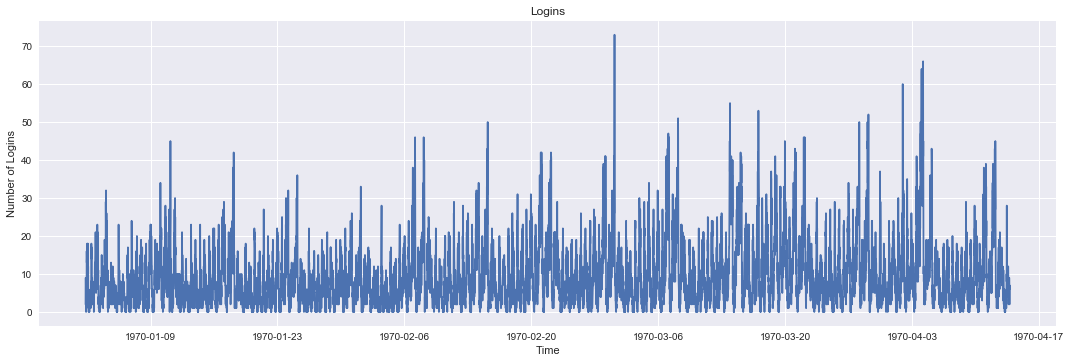

In [3]:
# scatterplot of the binned data
fig, ax = plt.subplots(figsize = (15,5))
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.tight_layout()
plt.title('Logins')
plt.plot(logins_delta15.index, logins_delta15.login_count)

<div class="alert alert-warning">
<strong>It does look like there is an underlying pattern in the data, but it is hard to see at this scale.  
    </strong>
</div>
    

<div class="alert alert-success">
<H3> Better understand time-series data </H3>
    <ol>
        <li>Look at the entire time-series with larger chunksize</li>
        <li>Look at specific days separately</li>
        <li>Find the busiest time of day</li>
    </ol>
</div>

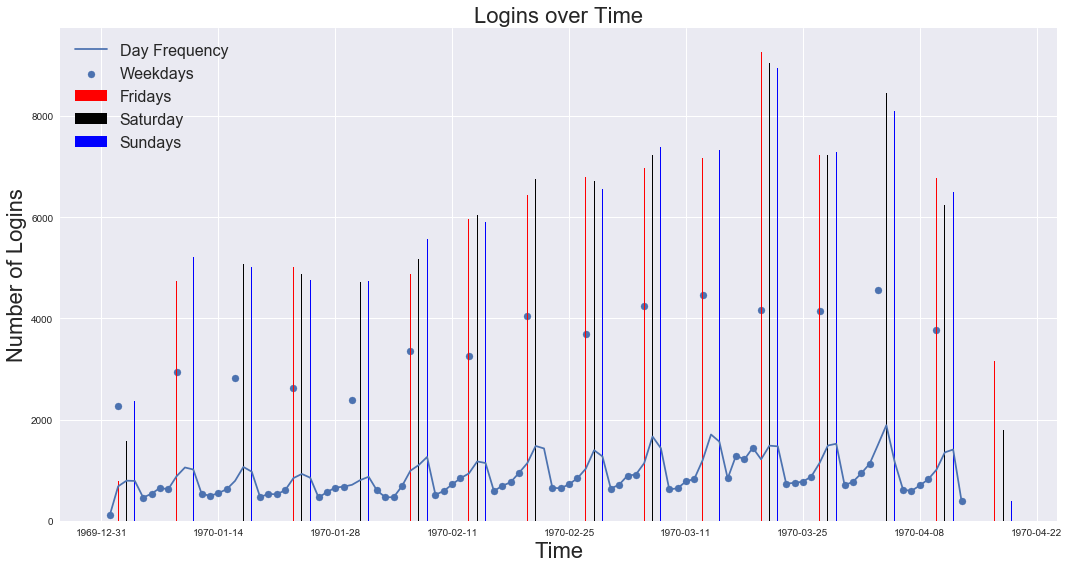

In [4]:
# bin data by the day
logins_daily = login_data.resample('D').sum()
logins_biz_day = login_data.resample('B').sum()
fridays = login_data.resample('W-FRI').sum()
saturdays = login_data.resample('W-SAT').sum()
sundays = login_data.resample('W-SUN').sum()


# line, scatterplot, and histograms of the binned data
fig, ax = plt.subplots(figsize = (15,8))
plt.xlabel('Time', fontsize = 22)
plt.ylabel('Number of Logins', fontsize = 22)
plt.title('Logins over Time', fontsize = 22)

plt.bar(fridays.index, fridays.login_count, align= 'center', width = 0.1, label = "Fridays", color = 'R')
plt.bar(saturdays.index, saturdays.login_count, label = 'Saturday', align = 'center', width = 0.1, color = 'Black')
plt.bar(sundays.index, sundays.login_count, label = "Sundays", align= 'center', width = 0.1, color = 'B')
plt.plot(logins_daily.index, logins_daily.login_count, label = 'Day Frequency')
plt.scatter(logins_biz_day.index, logins_biz_day.login_count, label='Weekdays')

plt.legend(loc='upper left', fontsize = 16)
plt.tight_layout()


<div class="alert alert-warning">
<strong>The above graph makes it clear that Friday has the most logins, and that the weekends are busier than the weekdays.</strong>
</div>

<div class="alert alert-success">
<H3> Find hourly trends by day of week</H3>
</div>

In [5]:
# resample index hourly
daily_logins = login_data.resample('H').sum()
# make a column that identify the day of week; Monday=0, Sunday=6
day_of_week = list(daily_logins.index.dayofweek)
daily_logins['day_of_week'] = day_of_week
# add column with just the hour (omiting the date)
daily_logins['hour'] = [time.hour for time in daily_logins.index]

In [6]:
# create dataframe of the average number of logins for each hour of each day
avg_hourly_logins = pd.pivot_table(daily_logins, values = 'login_count', index = 'hour', columns = 'day_of_week', aggfunc=np.mean).rename(columns= {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
# stack
avg_hourly_logins = avg_hourly_logins.stack(level=['day_of_week'])
# name the stack
avg_hourly_logins.name = 'avg_num_logins'
avg_hourly_logins_df = avg_hourly_logins.reset_index()

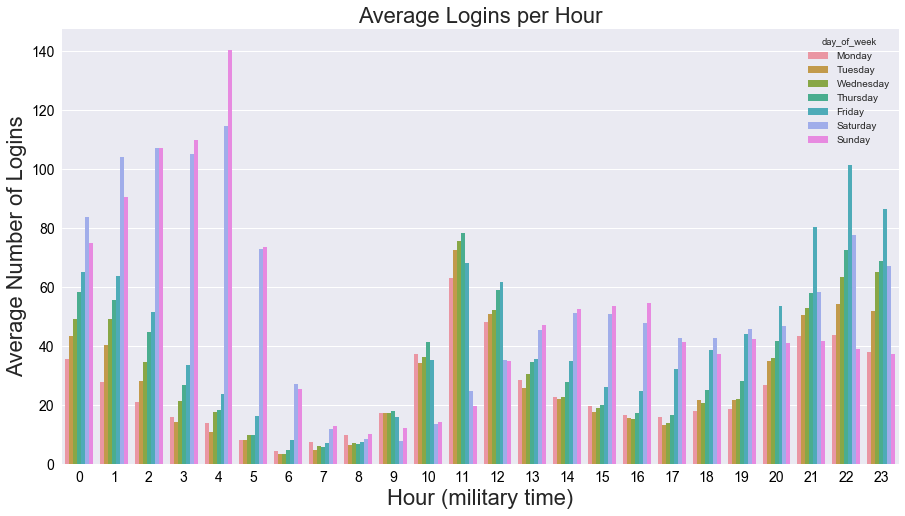

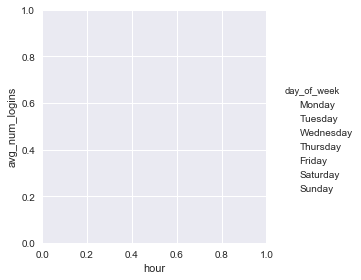

In [7]:
# plot average hourly use
fig, ax = plt.subplots(figsize = (15,8))
ax.set_title('Average Logins per Hour', fontsize = 22)
sns.factorplot(ax = ax, x='hour', y='avg_num_logins', data=avg_hourly_logins_df, kind = 'bar', hue='day_of_week')
ax.set_xlabel('Hour (military time)', fontsize = 22)
ax.set_ylabel('Average Number of Logins', fontsize = 22)
ax.tick_params(labelsize=14,labelcolor="black")

<div class="alert alert-warning">
<strong>The bar graph shows the heaviest usage occurs during the early hours (1 AM - 5 AM) on Saturday and Sunday.  During the weekdays there are smaller spikes in usage during lunch hours (11 am to noon), and in the evening (9 PM - 11 PM).</strong>
</div>

<div class="alert alert-info">
<H2> Part 2 ‑ Experiment and metrics design </H2>

<H3> 
<p>
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
</p>

<p>
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
    <ol>
        <li> What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?</li>
        <li> Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
            <ul>
                <li> how you will implement the experiment</li>
                <li> what statistical test(s) you will conduct to verify the significance of the observation</li>
                <li> how you would interpret the results and provide recommendations to the city operations team along with any caveats.</li> 
</ul>
    </ol>
 </H3>
</div>



*To clarify the problem I am making the following assumptions:*
1. There is an electronic record of the number of cars that use the bridge.  This is a reasonable assumption, as to reimburse the partner drivers, the drivers would need a record of crossing.
2. There is historical data on bridge use

The key metric I would use is change in weekday activity. Specifically, during the daytime hours on weekdays, is there an increase of cars entering the bridge from Gotham AND during the night is there an increase of cars entering the bridge from Metropolis.  I choose this metric because it required only two assumptions, is easily measured, and doesn't require waiting for reimbursement data to accumulate (as I don't know how long the reimbursement process takes).


In order to answer the above questions I would use two hypothesis tests.
1. H0: There is no difference between the mean number of cars entering the bridge from Gotham during weekdays between 6 am and 6 pm, two weeks before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.

   H2: There is an INCREASE in the mean number of cars entering the bridge from Gotham during weekdays between 6 am and 6 pm, two weeks before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.

2. H0: There is no difference between the mean number of cars entering the bridge from Metropolis during weekdays between 7 pm and 4 am, two weeks before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.

   H2: There is an INCREASE in the mean number of cars entering the bridge from Metropolis during weekdays between 7 pm and 4 am, two weeks before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered. 

I would use a one-tailed Z-test to determine the p-value of each hypothesis. 

If the p-value is less than 0.05 for BOTH tests I would reject the null hypotheses and recommend the reimbursement program continue, with the caveat that the study should be repeated in a year with more data.

If the p-value is greater than 0.05 for BOTH tests I would fail to reject the null hypotheses and recommend that a different program be developed to increase partner driving between the two cities.

If the p-value is mixed, so only one hypothesis has a p-value less than 0.05 I would recommend that the analysis is inconclusive and that further investigation is needed.

<div class="alert alert-info">

<H2> Part 3 ‑ Predictive modeling </H2>

<p>
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
</p>

<p>
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
</p>

The data is in the attached file ultimate_data_challenge.json.
    <ol>
        <li> Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?</li>
        <li> Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
        <li> Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).</li>
                
    </ol>
 </H3>
</div>


<div class="alert alert-success">
<H3> Assumptions Made </H3>

The date of when the data was pulled is not given, so I cannot tell if they had a trip in the 30 days before that date, nor is a user ID given.

Thus, I will assume:
1. That the most recent trip taken was the day the data was pulled
2. Each row represents a summary of a unique user 

<div class="alert alert-success">
<H3> Cleaning and EDA </H3>
</div>

In [20]:
# load data
with open('data/ultimate_data_challenge.json') as f:
    data = json.load(f)

# put data info pandas dataframe
user_data = pd.DataFrame(data)

# convert dates to datetime objects
user_data['signup_date'] = pd.to_datetime(user_data['signup_date'])
user_data['last_trip_date'] = pd.to_datetime(user_data['last_trip_date'])

# find the date the data was pulled
pull_date = user_data.last_trip_date.max()

# determine 30 days previous to the pull day
cut_off_day = pull_date - pd.Timedelta('30 days')

# add active status to dataframe 0= inactive, 1 = active
user_data['active_status'] = (user_data.last_trip_date > cut_off_day).astype('int')

# add dummies to categorical data
user_data = pd.get_dummies(user_data, columns = ['city', 'phone'])

In [21]:
# separate the active and inactive users
active_user = user_data[user_data.active_status == 1]
inactive_user = user_data[user_data.active_status == 0]

In [22]:
# fraction of the observed users that were retained
fraction = round((len(active_user.active_status)/len(user_data.active_status)) * 100, 2)
print('{} percent of users were retained.'.format(fraction))

36.62 percent of users were retained.


In [30]:
# calculate the mean and standard deviation for each feature
feature_columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'city_Astapor',
 "city_King's Landing", 'city_Winterfell', 'phone_Android','phone_iPhone']
stats_dict = {}
for col in feature_columns:
    stats_dict[col] = [active_user[col].mean(), active_user[col].std(),
                       inactive_user[col].mean(),inactive_user[col].std()]

In [40]:
# create a dataframe of the statistics
stats_df = pd.DataFrame.from_dict(stats_dict, orient='index').rename(columns = {0:'active_mean', 1:'active_std', 2:'inactive_mean', 3:'inactive_std'})

Text(0.5,1,'Average of Features for Active and Inactive Users')

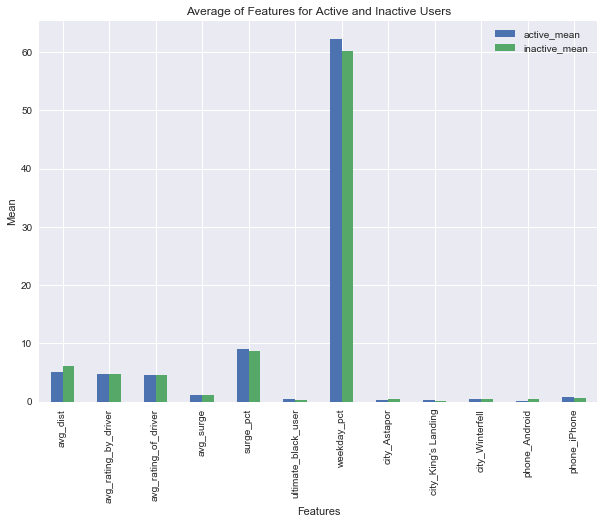

In [53]:
# visualize the statistics
stats_df[['active_mean', 'inactive_mean']].plot(kind = 'bar', yerr=stats_df[['active_std','inactive_std']], figsize = (10,7))
plt.xlabel('Features')
plt.ylabel('Mean')
plt.title('Average of Features for Active and Inactive Users')

<div class="alert alert-warning">
<strong>The bar graph of the statistcs shows there is not a pronounce difference between the average of the features for active and inactive users.  It also shows the weekday_pct feature has a much larger scale than the others, so the data may need to be normalized</strong>
</div>